In [218]:
import matplotlib.pyplot as plt 
from scipy.io import readsav
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from matplotlib import colors
import cmasher as cmr
import sunpy.cm as cm #The functionality of the sunpy.cm module is now in sunpy.visualization.colormaps as of SunPy 1.1
from tqdm import tqdm
from helita.io import lp
import COCOpy as cp
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import label, regionprops
import matplotlib as mpl

In [2]:
dpath_SST = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/'
dpath_SST_processed = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/souvikb_CBP/'
dpath_EDVARDA_SDO = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/edvarda/sdo2sst/' 
dpath_SDO_BOSE ='/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/souvikb_CBP/SDO_only_aia/'

In [24]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values."
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap
mycmap = transparent_cmap(plt.cm.jet)

# SST data

In [3]:
hdrH_im =lp.getheader(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
hdrH_sp = lp.getheader(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])

hdr_dopp = lp.getheader(dpath_SST_processed+'Dopplergram_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_dopp = hdr_dopp[0]
cube_dopp = lp.getdata(dpath_SST_processed+'Dopplergram_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_dopp = np.reshape(cube_dopp,[dim_dopp[0],dim_dopp[1],dim_dopp[2]])

hdr_rbe_mask = lp.getheader(dpath_SST_processed+'Unshrped_RBEs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_rbe_mask = hdr_rbe_mask[0]
cube_rbe_mask = lp.getdata(dpath_SST_processed+'Unshrped_RBEs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_rbe_mask = np.reshape(cube_rbe_mask,[dim_rbe_mask[0],dim_rbe_mask[1],dim_rbe_mask[2]])

hdr_rre_mask = lp.getheader(dpath_SST_processed+'Unsrhped_RREs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_rre_mask = hdr_rre_mask[0]
cube_rre_mask = lp.getdata(dpath_SST_processed+'Unsrhped_RREs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_rre_mask = np.reshape(cube_rre_mask,[dim_rre_mask[0],dim_rre_mask[1],dim_rre_mask[2]])
#cube_dopp=np.swapaxes(cube_dopp,0,1)

time_steps = readsav(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im_times+wvl.idlsave')
times = time_steps['times']

# SDO data

In [145]:
##------ Original SDO in .fits form -----------
aia_171 = np.swapaxes(fits.getdata(dpath_SDO_BOSE+'aia_171_bose.fits',ext=0),0,2)
aia_193 = np.swapaxes(fits.getdata(dpath_SDO_BOSE+'aia_193_bose.fits',ext=0),0,2)
aia_211 = np.swapaxes(fits.getdata(dpath_SDO_BOSE+'aia_211_bose.fits',ext=0),0,2)
aia_304 = np.swapaxes(fits.getdata(dpath_SDO_BOSE+'aia_304_bose.fits',ext=0),0,2)
aia_131 = np.swapaxes(fits.getdata(dpath_SDO_BOSE+'aia_131_bose.fits',ext=0),0,2)
hmi_mag = np.swapaxes(fits.getdata(dpath_SDO_BOSE+'hmi_mag_bose.fits',ext=0),0,2)

##------ Enhanced by simple unsharp masking and common difference -----
aia_171_idl = readsav(dpath_SDO_BOSE+'aia171_enhanced.sav')
aia_193_idl = readsav(dpath_SDO_BOSE+'aia193_enhanced.sav')
aia_304_idl = readsav(dpath_SDO_BOSE+'aia304_enhanced.sav')
aia_131_idl = readsav(dpath_SDO_BOSE+'aia131_enhanced.sav')
aia_211_idl = readsav(dpath_SDO_BOSE+'aia211_enhanced.sav')

aia_171_enh = np.swapaxes(np.array(aia_171_idl['enhanced_aia_cube']),0,2)
aia_193_enh = np.swapaxes(np.array(aia_193_idl['enhanced_aia_cube']),0,2)
aia_304_enh = np.swapaxes(np.array(aia_304_idl['enhanced_aia_cube']),0,2)
aia_131_enh = np.swapaxes(np.array(aia_131_idl['enhanced_aia_cube']),0,2)
aia_211_enh = np.swapaxes(np.array(aia_211_idl['enhanced_aia_cube']),0,2)

#------- Reading MGN processed AIA cubes ---------
hf_304 = h5py.File(dpath_SDO_BOSE+'MGN_AIA_304.hdf5','r')
mgn_304 = hf_304['Processed_304']
hf_171 = h5py.File(dpath_SDO_BOSE+'MGN_AIA_171.hdf5','r')
mgn_171 = hf_171['Processed_171']
hf_193 = h5py.File(dpath_SDO_BOSE+'MGN_AIA_193.hdf5','r')
mgn_193 = hf_193['Processed_193']
hf_193 = h5py.File(dpath_SDO_BOSE+'MGN_AIA_211.hdf5','r')
mgn_211 = hf_193['Processed_211']

In [183]:
mgn_193.shape

(1796, 1138, 96)

## Labelling (D)RREs

In [5]:
#labelling the 3d cube
labeled_3d_red = label(cube_rre_mask,return_num=True, connectivity=2)
print("No. of Red labels :"+format(labeled_3d_red[1]))

No. of Red labels :9705


- Though we have performed the **labeling** in 3D the problem is not all these labels correspond to elongated (D)RREs, which makes the images look noisier.  
- Therefore an additional _ _filtering_ _ step is implemented which (after performing the initial 3D labeling) takes into account of only those labels that fulfil a certain area criterion.
- The criterion imposed is if the number of pixels associated with a label is less than 1000, then we ignore them.

### Computing the area of each label 

In [111]:
area_red = np.zeros((labeled_3d_red[1]))
#eccen_blue = area_blue*0.0379*0.0379
#length_blue
lab_red = area_red*0
for region in tqdm(regionprops(labeled_3d_red[0])):
    i=region.label
    area_red[i-1] = region.area
    lab_red[i-1] = region.label
#     if region.area <= 1000:
#         lab = region.label
#         labeled_3d_blu[0][np.where(labeled_3d_blu[0]==lab)]=0
#     else:
#         continue
        
    #eccen_blue[i] = region.eccentricity


100%|██████████| 9705/9705 [00:00<00:00, 40986.23it/s]


### Performing area thresholing according to the above criterion

In [112]:
index1_red = np.where(area_red<=1000)
index_labels_red= np.where(np.isin(labeled_3d_red[0],lab_red[index1_red]) == True)
labeled_3d_red[0][index_labels_red]=0

### Filtering the "clutter"

In [114]:
size = labeled_3d_red[0].shape
number_of_red_events_reduced = np.zeros((size[0],size[1]))
for row in tqdm(range(size[0])):
    for col in range(size[1]):
        if labeled_3d_red[0][row,col,:].any()!=0:
            u = np.unique(labeled_3d_red[0][row,col,:])
            number_of_red_events_reduced[row,col] = len(np.where(u!=0)[0])
        else :
            number_of_red_events_reduced[row,col] = 0.          


100%|██████████| 1796/1796 [00:12<00:00, 139.16it/s]


In [20]:
##--- The snippet below is obsolete as it does not consider the filtered version----##
size = labeled_3d_red[0].shape
number_of_red_events = np.zeros((size[0],size[1]))
for row in tqdm(range(size[0])):
    for col in range(size[1]):
        if labeled_3d_red[0][row,col,:].any()!=0:
            u = np.unique(labeled_3d_red[0][row,col,:])
            number_of_red_events[row,col] = len(np.where(u!=0)[0])
        else :
            number_of_red_events[row,col] = 0.          

100%|██████████| 1796/1796 [00:14<00:00, 122.24it/s]


## Labelling (D)RBEs

In [101]:
#labelling the 3d cube
labeled_3d_blu = label(cube_rbe_mask,return_num=True, connectivity=2)
print("No. of Blue labels :"+format(labeled_3d_blu[1]))

No. of Blue labels :8488


In [21]:
##--- The snippet below is obsolete as it does not consider the filtered version----##
# size = labeled_3d_blu[0].shape
# number_of_blu_events = np.zeros((size[0],size[1]))
# for row in tqdm(range(size[0])):
#     for col in range(size[1]):
#         if labeled_3d_blu[0][row,col,:].any()!=0:
#             u = np.unique(labeled_3d_blu[0][row,col,:])
#             number_of_blu_events[row,col] = len(np.where(u!=0)[0])
#         else :
#             number_of_blu_events[row,col] = 0.          

100%|██████████| 1796/1796 [00:15<00:00, 115.97it/s]


In [102]:
area_blue = np.zeros((labeled_3d_blu[1]))
#eccen_blue = area_blue*0.0379*0.0379
#length_blue
lab_blue = area_blue*0
for region in tqdm(regionprops(labeled_3d_blu[0])):
    i=region.label
    area_blue[i-1] = region.area
    lab_blue[i-1] = region.label
#     if region.area <= 1000:
#         lab = region.label
#         labeled_3d_blu[0][np.where(labeled_3d_blu[0]==lab)]=0
#     else:
#         continue
        
    #eccen_blue[i] = region.eccentricity


100%|██████████| 8488/8488 [00:00<00:00, 39136.66it/s]


In [103]:
index1 = np.where(area_blue<=1000)
index_labels= np.where(np.isin(labeled_3d_blu[0],lab_blue[index1]) == True)
labeled_3d_blu[0][index_labels]=0

In [104]:
size = labeled_3d_blu[0].shape
number_of_blu_events_reduced = np.zeros((size[0],size[1]))
for row in tqdm(range(size[0])):
    for col in range(size[1]):
        if labeled_3d_blu[0][row,col,:].any()!=0:
            u = np.unique(labeled_3d_blu[0][row,col,:])
            number_of_blu_events_reduced[row,col] = len(np.where(u!=0)[0])
        else :
            number_of_blu_events_reduced[row,col] = 0.          


100%|██████████| 1796/1796 [00:13<00:00, 136.12it/s]


In [1]:
levels2 = np.linspace(0, 5, 500)
fig, axs =plt.subplots(2,3,figsize=(18,8.4),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.0,wspace=0.00,left=0.1,right=0.9,top=0.9,bottom=0.1)
axs=axs.ravel()

axs[0].imshow(cubeH[400:1100,600:1120,35,0].T,origin='lower', cmap='gray',vmin=1500,vmax=2900,extent=[0,700*0.0379,0,520*0.0379])
axs[0].set_yticks([])
axs[0].set_xticks([])
im = axs[0].contourf(number_of_red_events_reduced[400:1100,600:1120].T+number_of_blu_events_reduced[400:1100,600:1120].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,700*0.0379,0,520*0.0379])
axs[0].text(.05, .9, r'H$\beta$ WB', transform=axs[0].transAxes, fontsize=15,color='yellow',weight='bold')

axs[1].imshow(hmi_mag[400:1100,600:1120,49].T,origin='lower', cmap='RdGy',vmin=-600,vmax=600,extent=[0,700*0.0379,0,520*0.0379])
axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].text(.05, .9, r'HMI B$_{\mathrm{LOS}}$', transform=axs[1].transAxes, fontsize=15,color='red',weight='bold')
#im = axs[1].contourf(number_of_red_events_reduced[400:1100,600:1120].T+number_of_blu_events_reduced[400:1100,600:1120].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,700*0.0379,0,520*0.0379])

axs[2].imshow(aia_304[400:1100,600:1120,35].T,origin='lower', cmap='gray',extent=[0,700*0.0379,0,520*0.0379],vmin=6500,vmax=16000)
axs[2].set_yticks([])
axs[2].set_xticks([])
im = axs[2].contourf(number_of_red_events_reduced[400:1100,600:1120].T+number_of_blu_events_reduced[400:1100,600:1120].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,700*0.0379,0,520*0.0379],alpha=.06)
axs[2].text(.05, .9, r'30.4 nm', transform=axs[2].transAxes, fontsize=15,color='yellow',weight='bold')

axs[3].imshow(mgn_171[400:1100,600:1120,35].T,origin='lower', cmap='gray',extent=[0,700*0.0379,0,520*0.0379],vmax=0.7,vmin=0.5)
im = axs[3].contourf(number_of_red_events_reduced[400:1100,600:1120].T+number_of_blu_events_reduced[400:1100,600:1120].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,700*0.0379,0,520*0.0379],alpha=.06)
axs[3].set_xlabel('X [arcsec]')
axs[3].set_ylabel('Y [arcsec]')
axs[3].set_yticks([0,5,10,15])
axs[3].text(.05, .9, r'17.1 nm', transform=axs[3].transAxes, fontsize=15,color='yellow',weight='bold')

axs[4].imshow(mgn_193[400:1100,600:1120,35].T,origin='lower', cmap='gray',extent=[0,700*0.0379,0,520*0.0379],vmax=0.75,vmin=0.45)
axs[4].set_yticks([])
axs[4].set_xticks([])
im = axs[4].contourf(number_of_red_events_reduced[400:1100,600:1120].T+number_of_blu_events_reduced[400:1100,600:1120].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,700*0.0379,0,520*0.0379], alpha=.06)
axs[4].text(.05, .9, r'19.3 nm', transform=axs[4].transAxes, fontsize=15,color='yellow',weight='bold')

axs[5].imshow(mgn_211[400:1100,600:1120,35].T,origin='lower', cmap='gray',extent=[0,700*0.0379,0,520*0.0379],vmax=0.75,vmin=0.5)
axs[5].set_yticks([])
axs[5].set_xticks([])
im = axs[5].contourf(number_of_red_events_reduced[400:1100,600:1120].T+number_of_blu_events_reduced[400:1100,600:1120].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,700*0.0379,0,520*0.0379],alpha=.06)
axs[5].text(.05, .9, r'21.1 nm', transform=axs[5].transAxes, fontsize=15,color='yellow',weight='bold')

cmap = mpl.cm.jet
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.2, 0.01, 0.5])#[left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=5)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm)
cb1.set_ticks([0, 1, 2, 3, 4, 5 ])
cb1.set_ticklabels(["0", "1", "2","3", "4", "5"])
cb1.set_label('# of detected spicules')
#plt.savefig('/mn/stornext/d9/souvikb/CBP_spicules_SDO/'+'Pop_dense_spicules.png',dpi=400,bbox_inches = 'tight',pad_innches=0.1)



NameError: name 'np' is not defined

## For the full FOV

/astro/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_innches" which is no longer supported as of 3.3 and will become an error two minor releases later


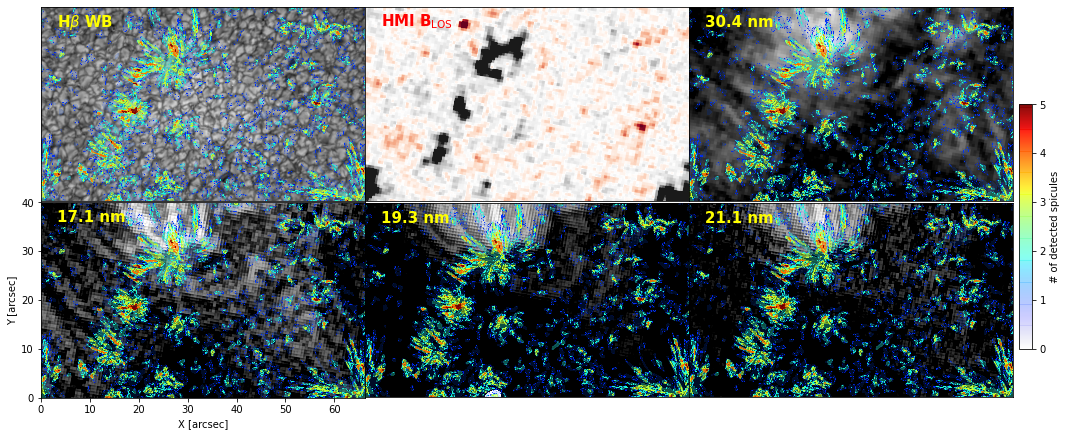

In [294]:
levels2 = np.linspace(0, 5, 500)
fig, axs =plt.subplots(2,3,figsize=(18,6.8),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.0,wspace=0.00,left=0.1,right=0.9,top=0.9,bottom=0.1)
axs=axs.ravel()

axs[0].imshow(cubeH[20:1768,50:1100,35,0].T,origin='lower', cmap='gray',vmin=1500,vmax=2900,extent=[0,1748*0.0379,0,1050*0.0379])
axs[0].set_yticks([])
axs[0].set_xticks([])
im = axs[0].contourf(number_of_red_events_reduced[20:1768,50:1100].T+number_of_blu_events_reduced[20:1768,50:1100].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,1748*0.0379,0,1050*0.0379])
axs[0].text(.05, .9, r'H$\beta$ WB', transform=axs[0].transAxes, fontsize=15,color='yellow',weight='bold')

axs[1].imshow(hmi_mag[20:1768,50:1100,35].T,origin='lower', cmap='RdGy',vmin=-600,vmax=600,extent=[0,1748*0.0379,0,1050*0.0379])
axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].text(.05, .9, r'HMI B$_{\mathrm{LOS}}$', transform=axs[1].transAxes, fontsize=15,color='red',weight='bold')
#im = axs[1].contourf(number_of_red_events_reduced[400:1100,600:1120].T+number_of_blu_events_reduced[400:1100,600:1120].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,700*0.0379,0,520*0.0379])

axs[2].imshow(aia_304[20:1768,50:1100,35].T,origin='lower', cmap='gray',extent=[0,1748*0.0379,0,1050*0.0379],vmin=6500,vmax=16000)
axs[2].set_yticks([])
axs[2].set_xticks([])
im = axs[2].contourf(number_of_red_events_reduced[20:1768,50:1100].T+number_of_blu_events_reduced[20:1768,50:1100].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,1748*0.0379,0,1050*0.0379],)
axs[2].text(.05, .9, r'30.4 nm', transform=axs[2].transAxes, fontsize=15,color='yellow',weight='bold')

axs[3].imshow(mgn_171[20:1768,50:1100,35].T,origin='lower', cmap='gray',extent=[0,1748*0.0379,0,1050*0.0379],vmax=0.7,vmin=0.5)
im = axs[3].contourf(number_of_red_events_reduced[20:1768,50:1100].T+number_of_blu_events_reduced[20:1768,50:1100].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,1748*0.0379,0,1050*0.0379],)
axs[3].set_xlabel('X [arcsec]')
axs[3].set_ylabel('Y [arcsec]')
axs[3].set_yticks([0,10,20,30,40])
axs[3].text(.05, .9, r'17.1 nm', transform=axs[3].transAxes, fontsize=15,color='yellow',weight='bold')

axs[4].imshow(mgn_193[20:1768,50:1100,35].T,origin='lower', cmap='gray',extent=[0,1748*0.0379,0,1050*0.0379],vmax=0.75,vmin=0.45)
axs[4].set_yticks([])
axs[4].set_xticks([])
im = axs[4].contourf(number_of_red_events_reduced[20:1768,50:1100].T+number_of_blu_events_reduced[20:1768,50:1100].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,1748*0.0379,0,1050*0.0379])
axs[4].text(.05, .9, r'19.3 nm', transform=axs[4].transAxes, fontsize=15,color='yellow',weight='bold')

axs[5].imshow(mgn_211[20:1768,50:1100,35].T,origin='lower', cmap='gray',extent=[0,1748*0.0379,0,1050*0.0379],vmax=0.75,vmin=0.5)
axs[5].set_yticks([])
axs[5].set_xticks([])
im = axs[5].contourf(number_of_red_events_reduced[20:1768,50:1100].T+number_of_blu_events_reduced[20:1768,50:1100].T,origin='lower',cmap=mycmap,levels=levels2, vmin=0, vmax=5,extent=[0,1748*0.0379,0,1050*0.0379])
axs[5].text(.05, .9, r'21.1 nm', transform=axs[5].transAxes, fontsize=15,color='yellow',weight='bold')

cmap = mpl.cm.jet
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.2, 0.01, 0.5])#[left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=5)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm)
cb1.set_ticks([0, 1, 2, 3, 4, 5 ])
cb1.set_ticklabels(["0", "1", "2","3", "4", "5"])
cb1.set_label('# of detected spicules')
plt.savefig('/mn/stornext/d9/souvikb/CBP_spicules_SDO/'+'Pop_dense_spicules_fullFOV.png',dpi=400,bbox_inches = 'tight',pad_innches=0.1)
plt.show()